In [4]:
import numpy as np

def create_input_space(categorical_data, continuous_data):
    """
    Creates a simple structured input space.
    
    Parameters:
    - categorical_data (dict): Keys are categorical variable names, values are lists of possible categories.
    - continuous_data (dict): Keys are variable names, values are (min, max) tuples.
    
    Returns:
    - bounds (np.array): Bounds for continuous variables.
    - labeled_input_space (list): List of input labels in the format h1, h2, x1, x2...
    """
    labeled_input_space = []
    continuous_count = 1
    bounds = []
    
    # Add labels for categorical variables (just integers for simplicity)
    categorical_count = 1
    for cat_var, categories in categorical_data.items():
        labeled_input_space.append(f"h{categorical_count}")
        categorical_count += 1
    
    # Add labels for continuous variables and bounds
    for cont_var, (min_val, max_val) in continuous_data.items():
        bounds.append([min_val, max_val])
        labeled_input_space.append(f"x{continuous_count}")
        continuous_count += 1
    
  
    return np.array(bounds), labeled_input_space

# Example case
categorical_data = {
    "Category1": [0, 1],  # 2 choices
    "Category2": [0, 1, 2]  # 3 choices
}
continuous_data = {
    "Var1": (0, 1),
    "Var2": (0, 1),
    "Var3": (0, 1),
    "Var4": (0, 1)
}

bounds, labeled_input_space = create_input_space(categorical_data, continuous_data)
print("Continuous Bounds:", bounds)
print("Labeled Input Space:", labeled_input_space)


Continuous Bounds: [[0 1]
 [0 1]
 [0 1]
 [0 1]]
Labeled Input Space: ['h1', 'h2', 'x1', 'x2', 'x3', 'x4']


In [7]:
import torch
import numpy as np
from botorch.models import SingleTaskGP
from gpytorch.likelihoods import GaussianLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf

# Define the EXP3 algorithm for categorical optimization
class EXP3:
    def __init__(self, n_arms, gamma=0.1):
        self.n_arms = n_arms
        self.gamma = gamma
        self.weights = np.ones(n_arms)  # Initialize the weights
        self.total_reward = 0

    def select_arm(self):
        # Compute the probability distribution over arms
        prob_dist = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + (self.gamma / self.n_arms)
        # Select an arm based on the probability distribution
        return np.random.choice(self.n_arms, p=prob_dist)

    def update(self, arm, reward):
        # Update the weights based on the observed reward
        self.total_reward += reward
        self.weights[arm] *= np.exp(self.gamma * reward / (self.n_arms * np.sum(self.weights)))

# Example: Define categorical and continuous input spaces
categorical_data = {
    "Category1": [0, 1],  # 2 choices
    "Category2": [0, 1, 2]  # 3 choices
}
continuous_data = {
    "Var1": (0, 1),
    "Var2": (0, 1),
    "Var3": (0, 1),
    "Var4": (0, 1)
}

# Set up the GP model for continuous variables
def create_gp_model(train_x, train_y):
    likelihood = GaussianLikelihood()
    model = SingleTaskGP(train_x, train_y.unsqueeze(-1), likelihood=likelihood)
    return model

# Define the acquisition function
def optimize_continuous(model, bounds):
    acq_func = UpperConfidenceBound(model, beta=2.0)
    candidates, _ = optimize_acqf(acq_func, bounds=bounds, q=1, num_restarts=5, raw_samples=20)
    return candidates

# Initialize the EXP3 model for categorical optimization
n_arms = 3  # Example: 3 categorical choices
exp3 = EXP3(n_arms)

# Example: Initial continuous points for training the GP
train_x = torch.tensor([[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.7, 0.8], [0.9, 0.8, 0.7, 0.6]], dtype=torch.float64)
train_y = torch.tensor([0.5, 0.8, 0.6], dtype=torch.float64)  # Example target values

# Train the GP model
model = create_gp_model(train_x, train_y)

# Get the bounds for the continuous variables
bounds = torch.tensor([[0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0]])

# Simulate the optimization process
# Select a categorical arm (e.g., choose a category for Category1 and Category2)
selected_arm = exp3.select_arm()
print(f"Selected Categorical Arm: {selected_arm}")

# Optimize the continuous space using the GP model
continuous_candidate = optimize_continuous(model, bounds)
print(f"Suggested Continuous Candidate: {continuous_candidate}")

# Combine the results: The final input zt = [ht, xt]

# First reshape the selected_arm to match the continuous candidate shape
selected_arm_tensor = torch.tensor([selected_arm]).unsqueeze(0) #Shape [1,1] 
continuous_candidate_tensor = continuous_candidate # Shape [1,4]

# Here we assume `ht` is the selected categorical arm, and `xt` is the optimized continuous candidate
zt = torch.cat((selected_arm_tensor, continuous_candidate_tensor), dim=-1)  #BECAREFUL HERE AS THE INTEGER CATEGORIES WILL CONVERT TO FLOATS
print(f"Final input zt: {zt}")


Selected Categorical Arm: 2
Suggested Continuous Candidate: tensor([[0.2908, 0.6281, 0.9655, 1.0000]])
Final input zt: tensor([[2.0000, 0.2908, 0.6281, 0.9655, 1.0000]])


In [8]:
import torch
from gpytorch.kernels import Kernel, MaternKernel, ScaleKernel
from gpytorch.constraints import Interval

# Define a categorical kernel using a similarity matrix
class CategoricalKernel(Kernel):
    def __init__(self, similarity_matrix, **kwargs):
        super().__init__(**kwargs)
        self.similarity_matrix = similarity_matrix

    def forward(self, x1, x2, diag=False, **params):
        x1, x2 = x1.long().squeeze(), x2.long().squeeze()
        return self.similarity_matrix[x1, x2]

# Define the hybrid kernel (continuous + categorical)
class HybridKernel(Kernel):
    def __init__(self, cont_kernel, cat_kernel, **kwargs):
        super().__init__(**kwargs)
        self.cont_kernel = cont_kernel
        self.cat_kernel = cat_kernel
        self.lambda_param = torch.nn.Parameter(torch.tensor(0.5, dtype=torch.float64), requires_grad=True)
        self.register_constraint("lambda_param", Interval(0.0, 1.0))

    def forward(self, x1, x2, diag=False, **params):
        x1_cat, x1_cont = x1[:, 0], x1[:, 1:]
        x2_cat, x2_cont = x2[:, 0], x2[:, 1:]
        
        k_cat = self.cat_kernel(x1_cat, x2_cat, diag=diag, **params)
        k_cont = self.cont_kernel(x1_cont, x2_cont, diag=diag, **params)
        
        return self.lambda_param * k_cont + (1 - self.lambda_param) * k_cat

# Define a similarity matrix for categorical variables (example with 3 categories)
similarity_matrix = torch.tensor([
    [1.0, 0.5, 0.2],
    [0.5, 1.0, 0.3],
    [0.2, 0.3, 1.0],
], dtype=torch.float64)

# Instantiate the kernels
cat_kernel = CategoricalKernel(similarity_matrix)
cont_kernel = ScaleKernel(MaternKernel(nu=2.5))

# Create the hybrid kernel
hybrid_kernel = HybridKernel(cont_kernel, cat_kernel)

# Apply hybrid kernel to GP model
model.covar_module = hybrid_kernel


In [ ]:
#this could be a good idea for a montecarlo elbo... no this won't work, but ther ie monte carlo elbo


from gpytorch.mlls import VariationalELBO
import torch

class MonteCarloELBO(VariationalELBO):
    def forward(self, function_dist, target, *params, **kwargs):
        # Define a Monte Carlo approximation for the log-likelihood
        num_samples = 100  # Number of Monte Carlo samples
        log_prob_samples = []
        for _ in range(num_samples):
            sample = function_dist.rsample()
            log_prob_samples.append(function_dist.log_prob(target))
        
        return -torch.mean(torch.stack(log_prob_samples))

c:\Users\uqkmuroi\gitcode\bayesmediaopt\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\uqkmuroi\gitcode\bayesmediaopt\venv\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Iteration 0/50 - Loss: 415186.40625


c:\Users\uqkmuroi\gitcode\bayesmediaopt\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


Iteration 10/50 - Loss: 34289.1640625
Iteration 20/50 - Loss: 34344.81640625
Iteration 30/50 - Loss: 33330.984375
Iteration 40/50 - Loss: 32036.3671875


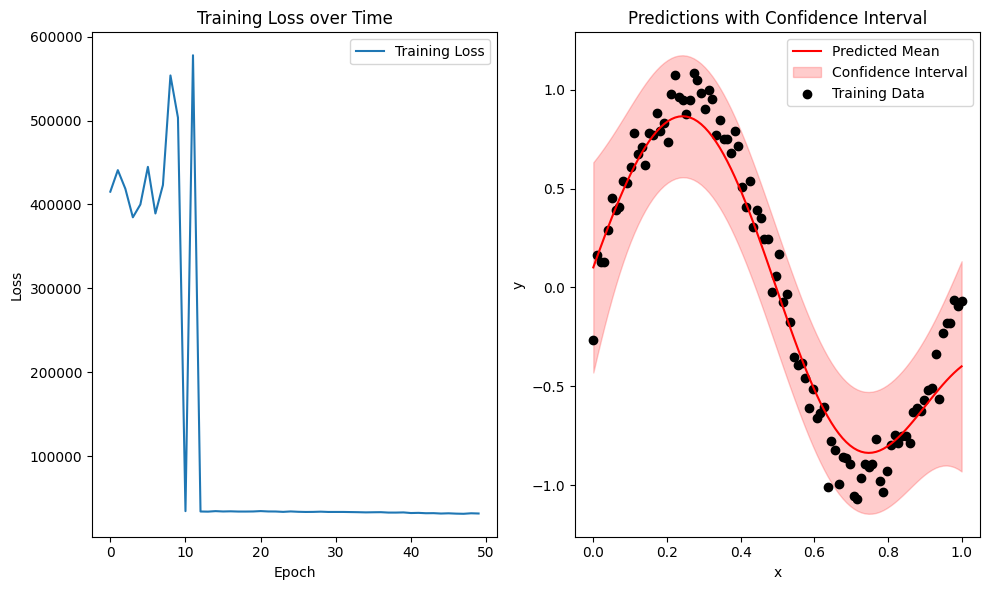

In [2]:
import torch
import gpytorch
import matplotlib.pyplot as plt

# Custom Monte Carlo ELBO definition
class MonteCarloELBO(gpytorch.mlls.VariationalELBO):
    def __init__(self, likelihood, model, num_data):
        super().__init__(likelihood, model, num_data)  # Pass num_data to parent class
        self.num_samples = 100  # Number of Monte Carlo samples

    def forward(self, function_dist, target, *params, **kwargs):
        log_prob_samples = []
        for _ in range(self.num_samples):
            sample = function_dist.rsample()
            log_prob_samples.append(function_dist.log_prob(target))
        
        return -torch.mean(torch.stack(log_prob_samples))


# Define a custom Exact GP model
class MyExactGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        # Define the kernel (RBF) and mean function
        self.covar_module = gpytorch.kernels.RBFKernel()
        self.mean_module = gpytorch.means.ConstantMean()

    def forward(self, x):
        # The forward pass: mean + kernel applied to input x
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Sample training data (replace with your actual data)
train_x = torch.linspace(0, 1, 100).unsqueeze(1)  # 100 points between 0 and 1
train_y = torch.sin(train_x * (2 * torch.pi)) + 0.1 * torch.randn_like(train_x)  # Noisy sine function
train_y = train_y.squeeze()  # Reshape train_y to be of shape [100]

# Define model and likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = MyExactGP(train_x, train_y, likelihood)

# Number of data points
num_data = train_x.size(0)

# Initialize Monte Carlo ELBO
mll = MonteCarloELBO(likelihood, model, num_data)

# Optimizer setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Tracking loss and predictions
losses = []
predictions = []
confidence_intervals = []

# Training loop
num_epochs = 50
for i in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(train_x)
    loss = mll(output, train_y)
    loss.backward()
    optimizer.step()
    
    # Store loss for plotting
    losses.append(loss.item())
    
    # Store predictions and confidence intervals for plotting
    model.eval()
    with torch.no_grad():
        test_x = torch.linspace(0, 1, 100).unsqueeze(1)  # Test points for predictions
        pred_dist = model(test_x)
        mean = pred_dist.mean
        lower, upper = pred_dist.confidence_region()
        predictions.append(mean)
        confidence_intervals.append((lower, upper))

    if i % 10 == 0:  # Print loss every 10 iterations
        print(f"Iteration {i}/{num_epochs} - Loss: {loss.item()}")

# Plotting the loss curve
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Time")
plt.legend()

# Plotting the predictions and confidence intervals
plt.subplot(1, 2, 2)
test_x = torch.linspace(0, 1, 100).unsqueeze(1)
test_x_np = test_x.numpy()
predictions_np = torch.stack(predictions).mean(dim=0).numpy()  # Mean over the training iterations
lower_np = torch.stack([x[0] for x in confidence_intervals]).mean(dim=0).numpy()  # Lower bounds
upper_np = torch.stack([x[1] for x in confidence_intervals]).mean(dim=0).numpy()  # Upper bounds

plt.plot(test_x_np, predictions_np, label="Predicted Mean", color='r')
plt.fill_between(test_x_np.flatten(), lower_np.flatten(), upper_np.flatten(), color='r', alpha=0.2, label="Confidence Interval")
plt.scatter(train_x.numpy(), train_y.numpy(), color='k', label="Training Data")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predictions with Confidence Interval")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()